# The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
# The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.

# Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.

In [3]:
# Import require librarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
from tensorflow.keras import layers
from keras.layers import Dropout
from tensorflow import keras
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from kerastuner.tuners import RandomSearch
from keras.layers import Dropout

In [4]:
# Load the data set 'gas_turbines.csv'
df = pd.read_csv('gas_turbines.csv')

In [5]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


# Pre processing or EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [7]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [8]:
df.duplicated().sum()

0

# There are no null values and duplicated values in the data

In [9]:
# Statistical summary of the data
df.describe().round(2)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00,15039.00
mean,17.76,1013.20,79.12,4.20,25.42,1083.80,545.40,134.19,12.10,1.97,68.19
std,7.57,6.41,13.79,0.76,4.17,16.53,7.87,15.83,1.10,2.22,10.47
min,0.52,985.85,30.34,2.09,17.88,1000.80,512.45,100.17,9.90,0.00,27.76
25%,11.41,1008.90,69.75,3.72,23.29,1079.60,542.17,127.98,11.62,0.86,61.30
50%,18.19,1012.80,82.27,4.19,25.08,1088.70,549.89,133.78,12.02,1.39,66.60
75%,23.86,1016.90,90.04,4.55,27.18,1096.00,550.06,140.89,12.58,2.16,73.94
max,34.93,1034.20,100.20,7.61,37.40,1100.80,550.61,174.61,15.08,44.10,119.89


In [10]:
corel = df.corr().round(2)

In [11]:
corel

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.00,-0.41,-0.55,-0.10,-0.05,0.09,0.34,-0.21,-0.10,-0.09,-0.60
AP,-0.41,1.00,0.04,0.04,0.08,0.03,-0.22,0.15,0.13,0.04,0.26
AH,-0.55,0.04,1.00,-0.12,-0.20,-0.25,0.01,-0.11,-0.18,0.17,0.14
AFDP,-0.10,0.04,-0.12,1.00,0.74,0.63,-0.57,0.72,0.73,-0.33,-0.04
GTEP,-0.05,0.08,-0.20,0.74,1.00,0.87,-0.76,0.98,0.99,-0.51,-0.21
TIT,0.09,0.03,-0.25,0.63,0.87,1.00,-0.36,0.89,0.89,-0.69,-0.23
TAT,0.34,-0.22,0.01,-0.57,-0.76,-0.36,1.00,-0.72,-0.74,0.06,0.01
TEY,-0.21,0.15,-0.11,0.72,0.98,0.89,-0.72,1.00,0.99,-0.54,-0.10
CDP,-0.10,0.13,-0.18,0.73,0.99,0.89,-0.74,0.99,1.00,-0.52,-0.17
CO,-0.09,0.04,0.17,-0.33,-0.51,-0.69,0.06,-0.54,-0.52,1.00,0.32


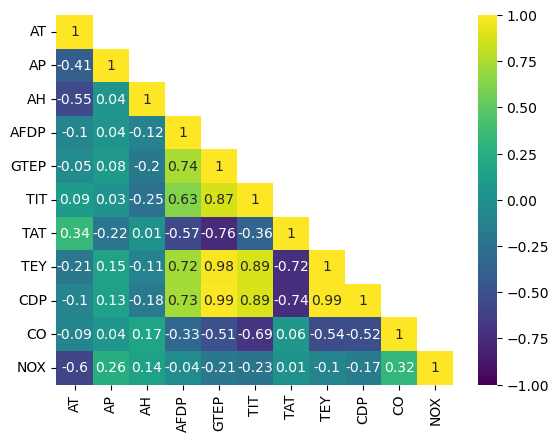

In [12]:
# Heat map visualization 
sns.heatmap(data = corel,vmin= -1,vmax = +1,annot = True,cmap='viridis',mask = np.triu(corel,1));

# From the above heatmap, we can say that there is a strong correlation between the independent variables GTEP and CDP, TIT and CDP.
# Similarly there is a strong correlation between the independent feature TIT and target feature TEY, and similarly between GTEP and TEY, between TEY and CDP

In [13]:
# CORRELATION WITH RESPECT TO TARGET VARIABLE TEY
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [14]:
numerical_features = df.describe(include= ['int64','float64']).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

# DATA VISUALIZATION

# Univariate plots

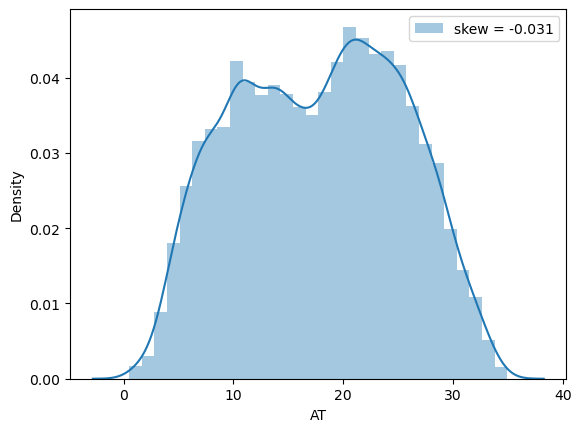

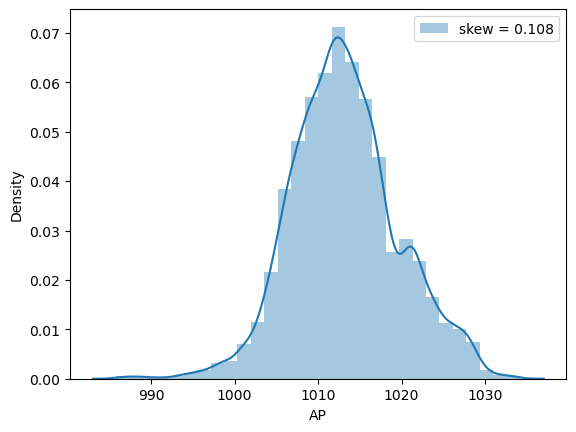

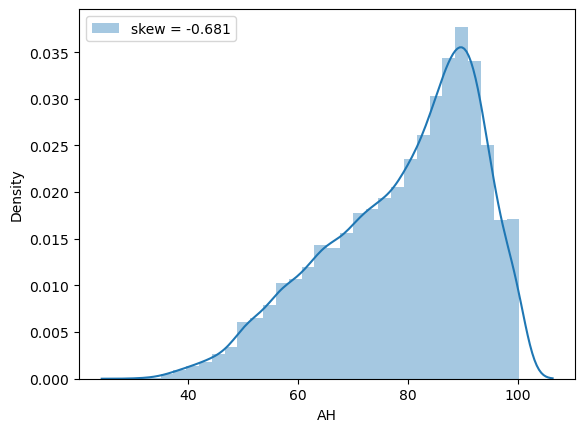

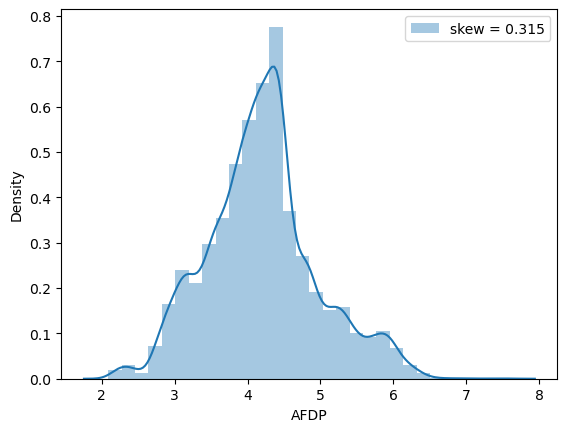

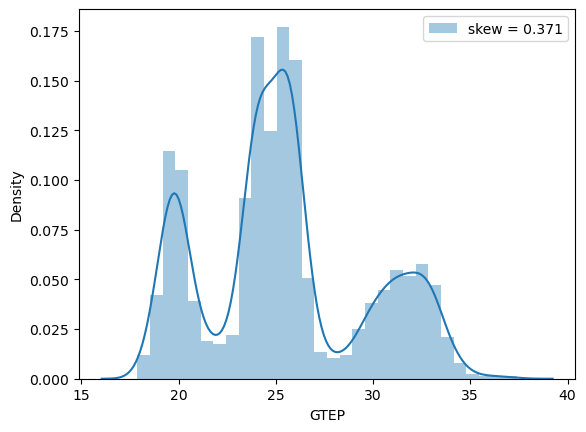

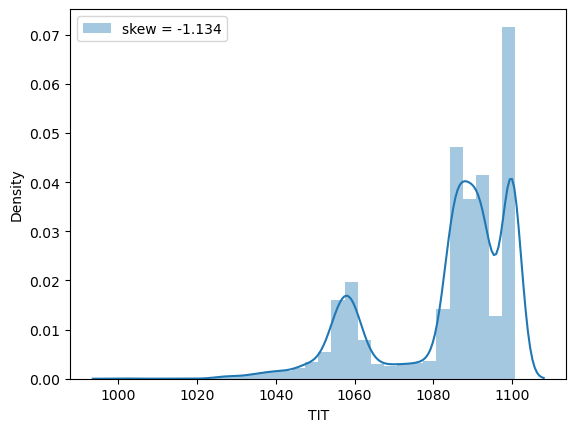

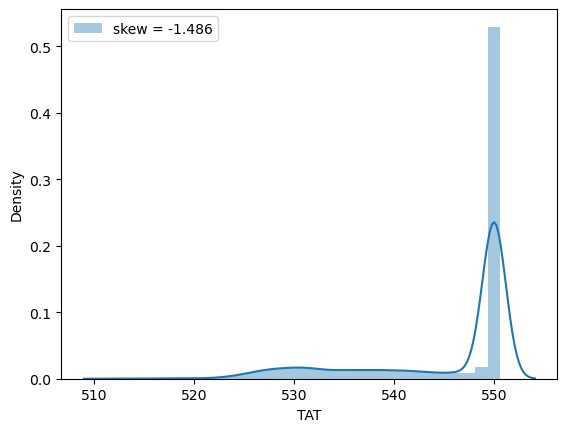

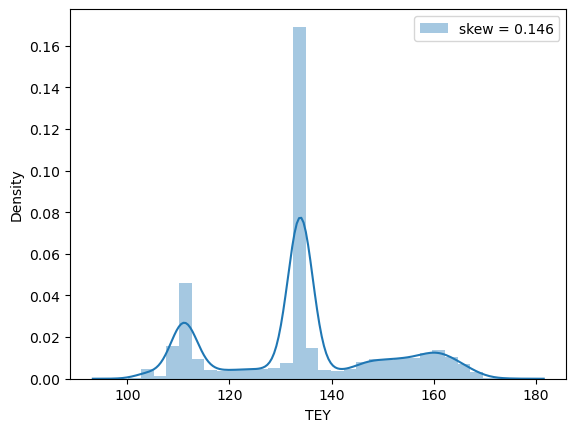

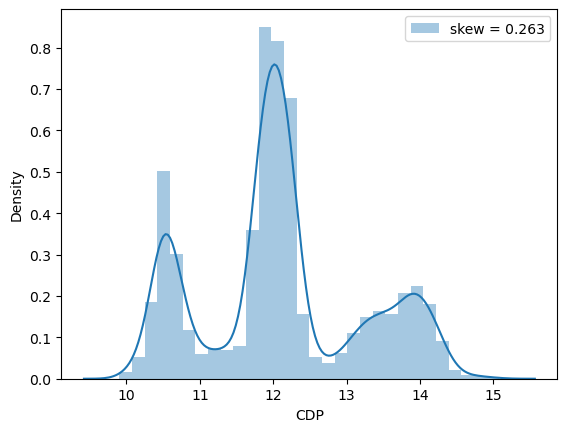

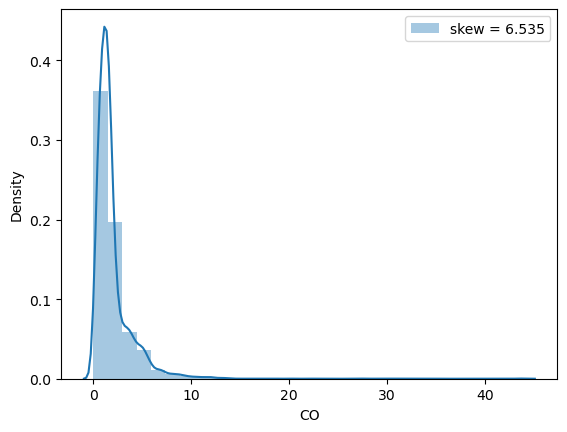

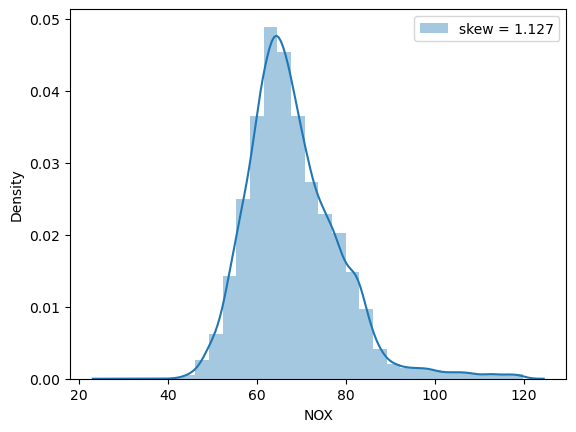

In [15]:
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat],kde= True,bins = 30,label = 'skew = %.3f' %(skew))
    plt.legend(loc = 'best')
    plt.show();

# We can observe there is a high skewness for features TIT, TAT and CO. And we can observe there are so many outliers in the some of the features

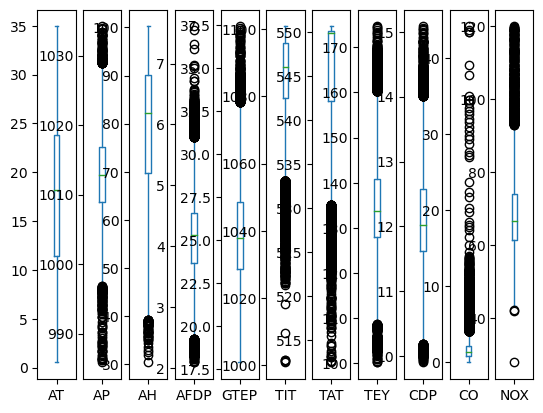

In [16]:
df.plot(kind = 'box',subplots = True);
plt.tight_layout();

# As we can see there are so many outliers in the data

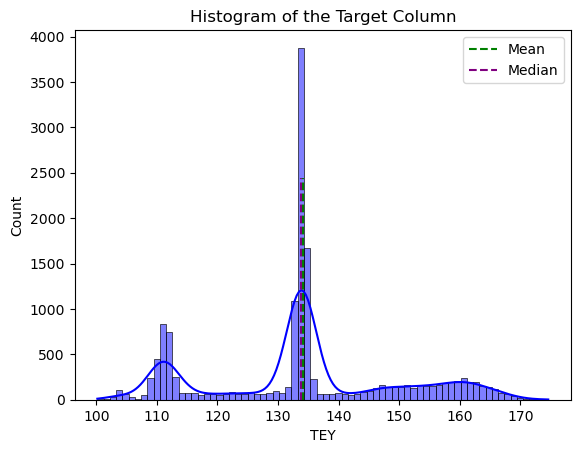

In [17]:
# Histogram of trget variable
sns.histplot(data = df,x= 'TEY',color='blue',kde = True)
plt.axvline(x=df["TEY"].mean(),ymax=0.60,color="green",linestyle='--',label="Mean")
plt.axvline(x=df["TEY"].median(),ymax=0.60,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column");

# Multivariate analysis with respect to TEY

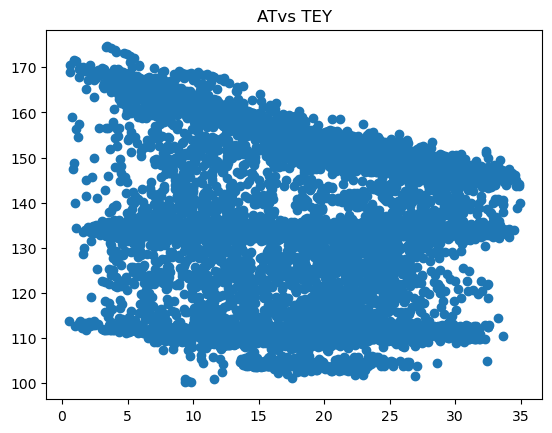

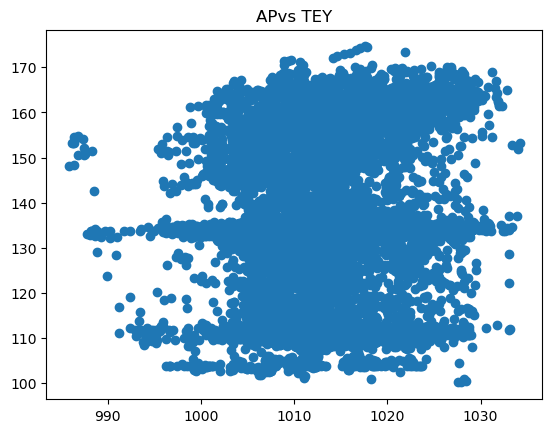

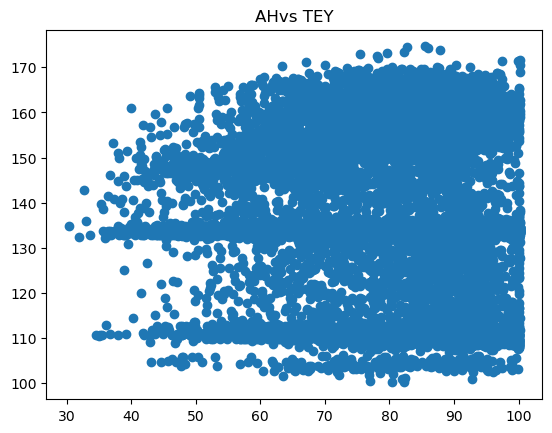

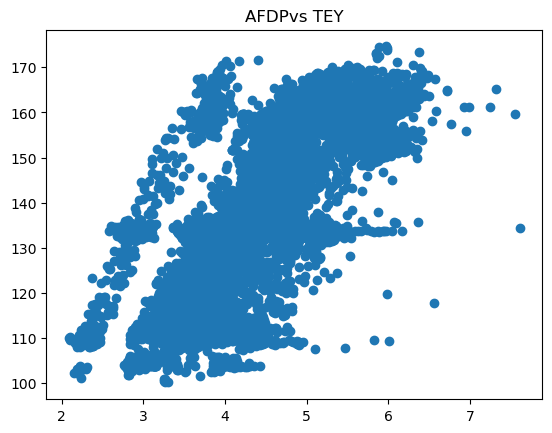

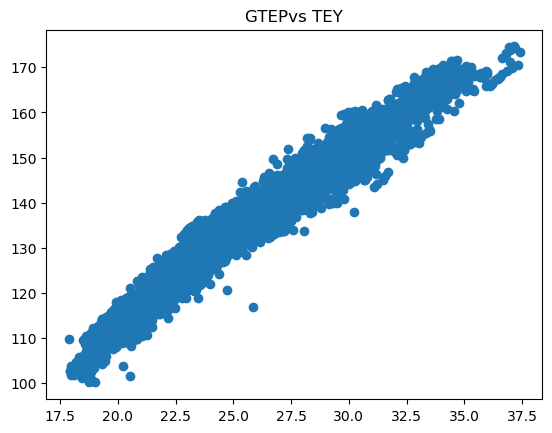

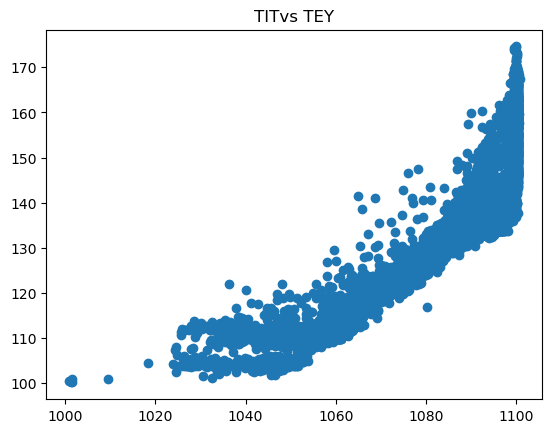

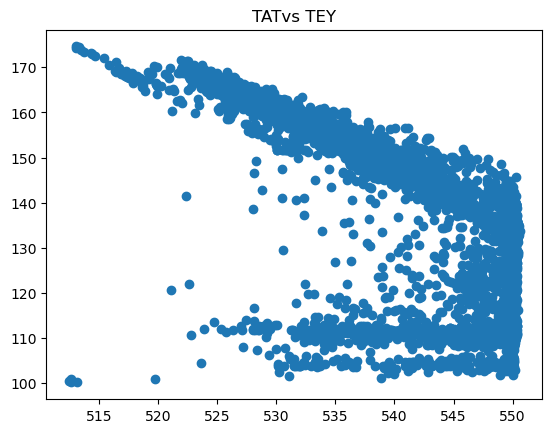

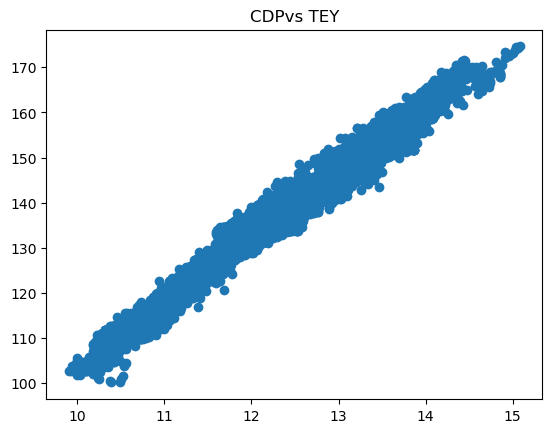

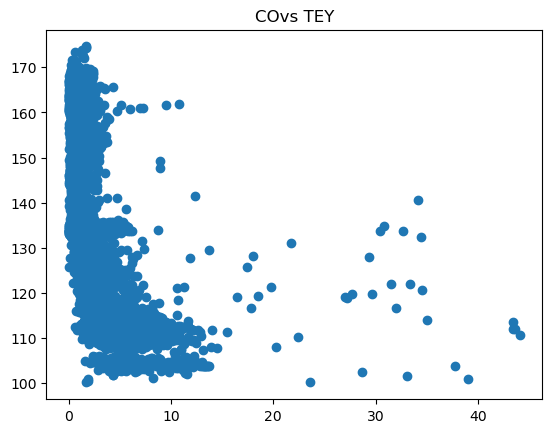

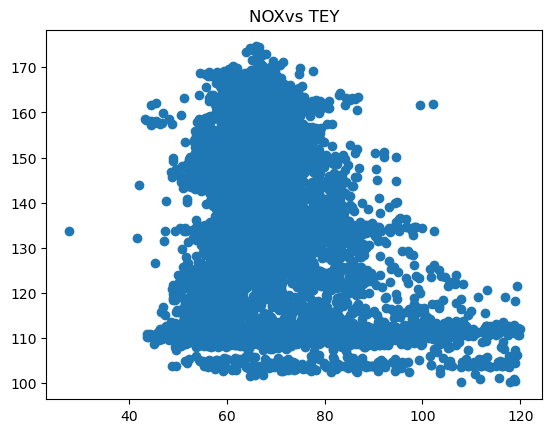

In [18]:
for i in df.columns:
    if i!='TEY':
        plt.scatter(df[i],df['TEY'])
        plt.title(i+ 'vs TEY')
        plt.show()

# As we can see TIT,TAT AND CO has strong correlation with TEY

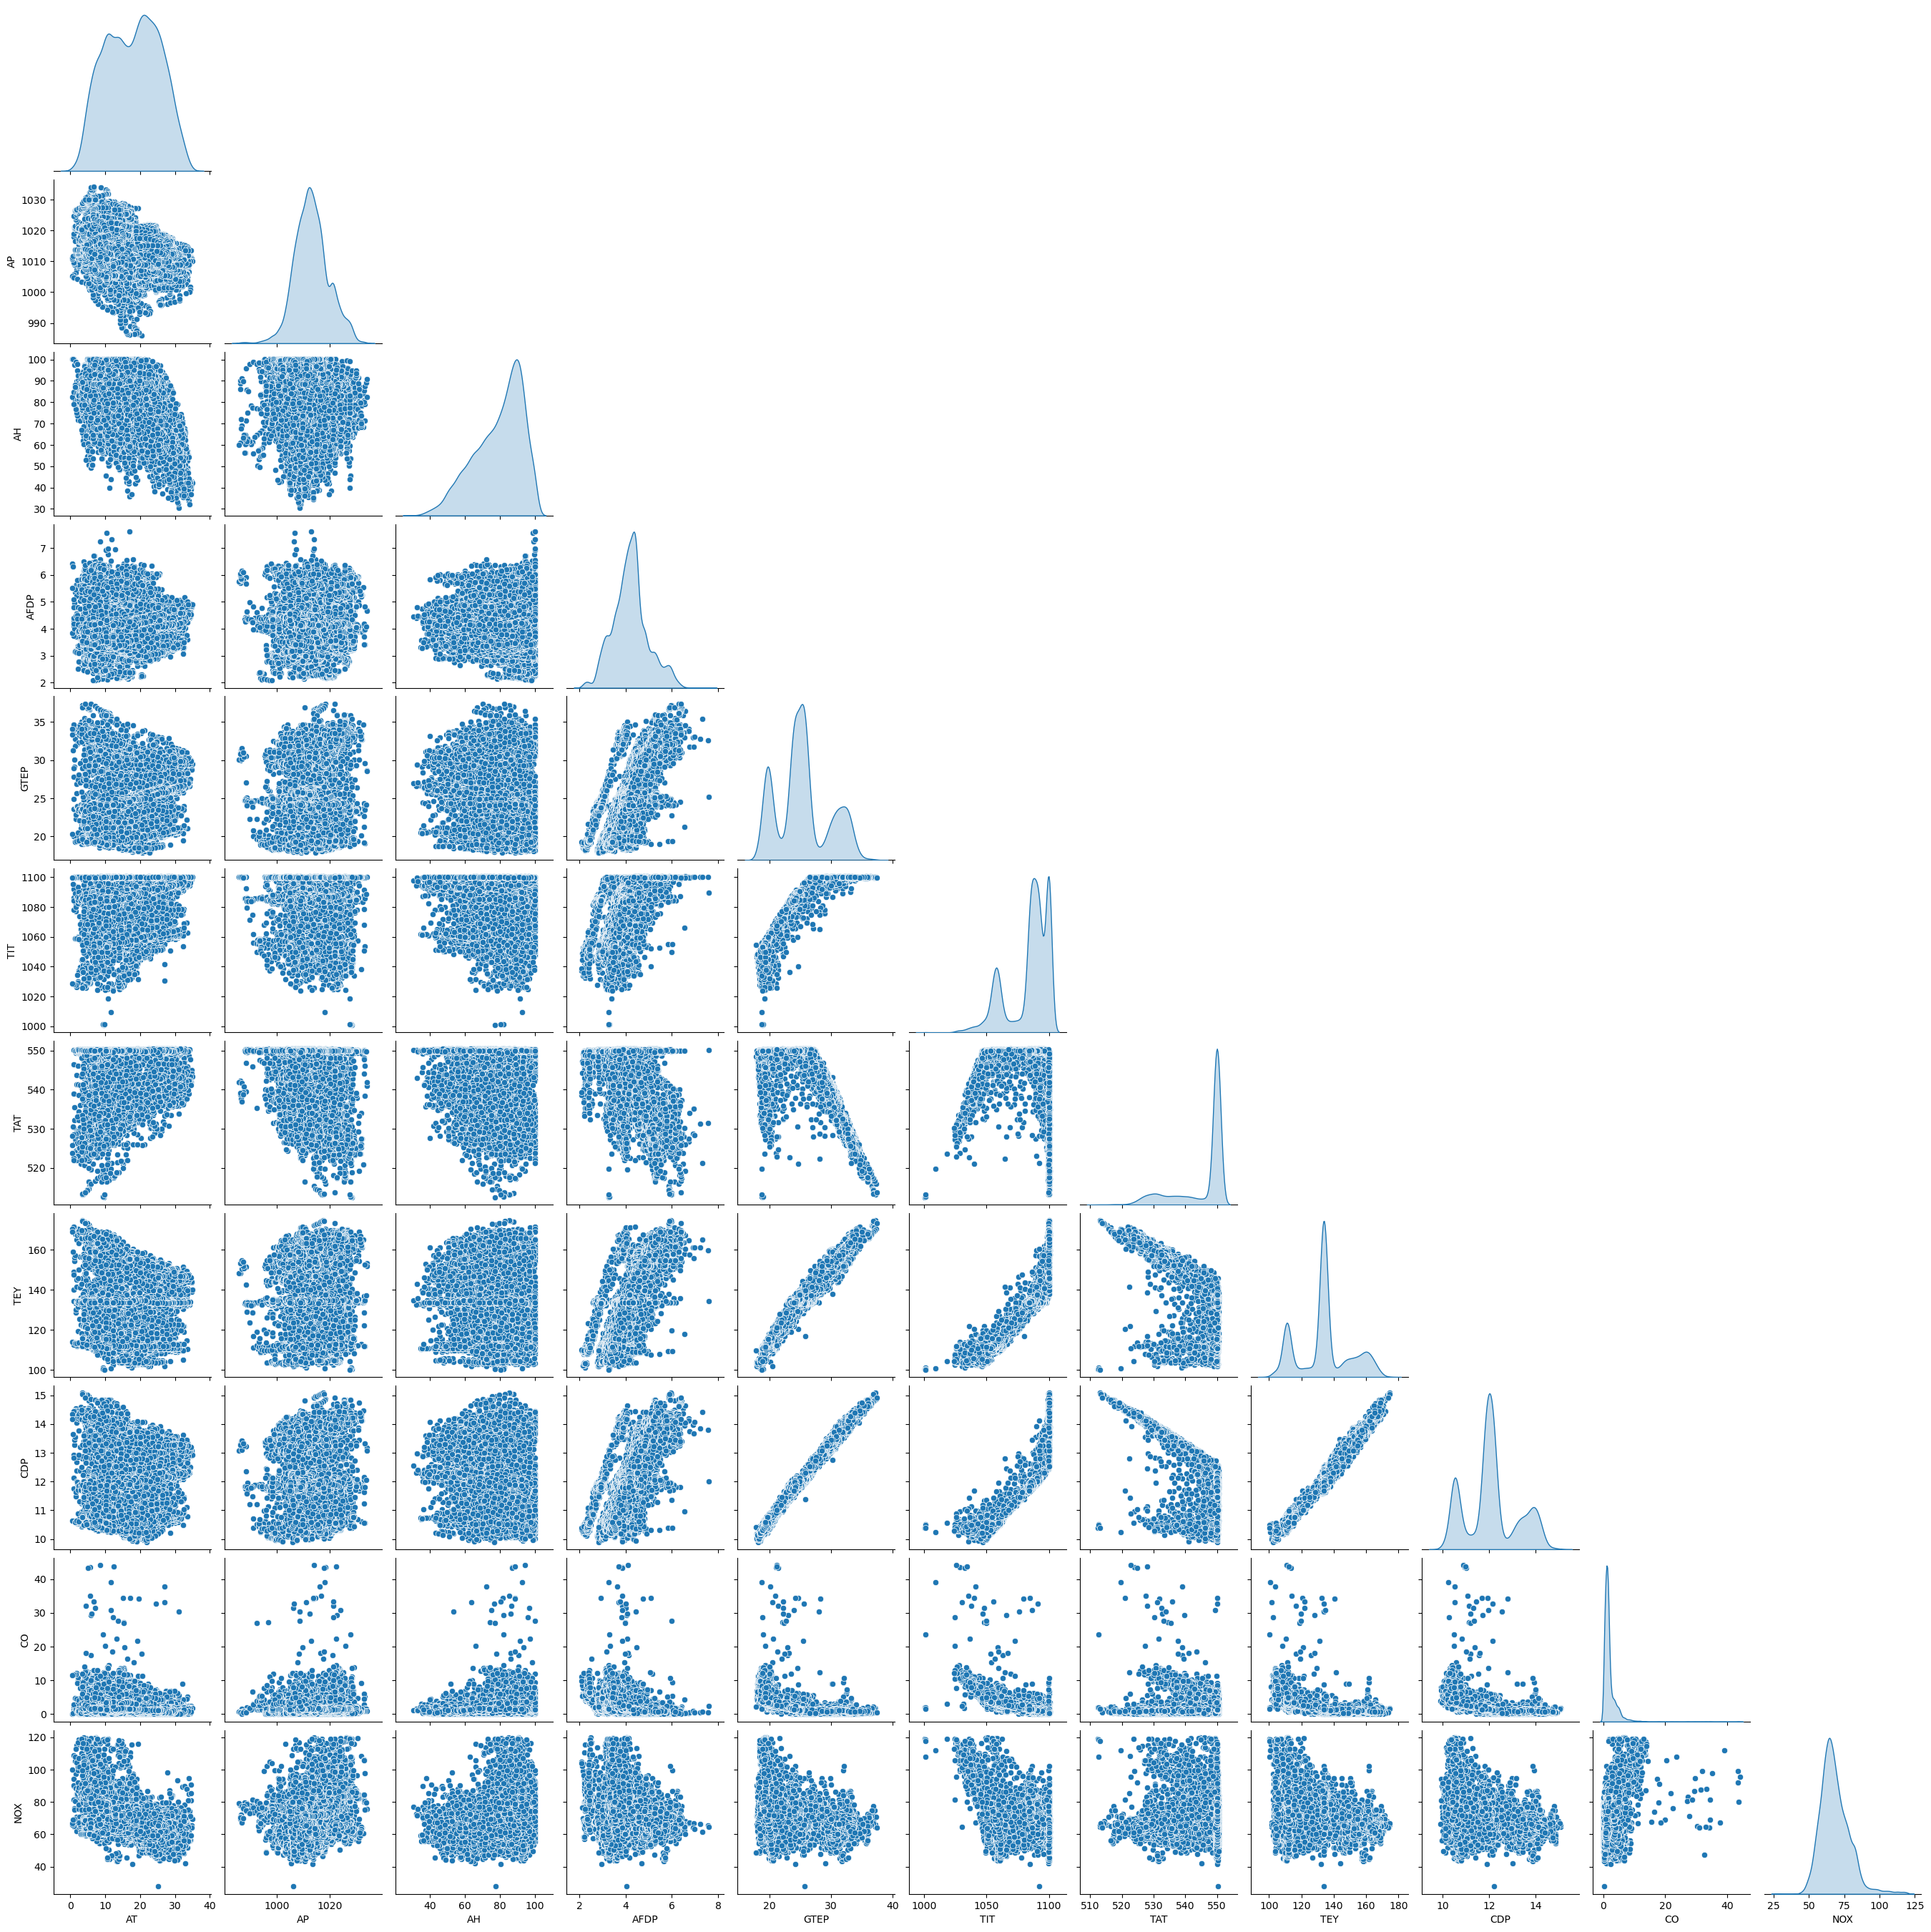

In [19]:
sns.pairplot(data = df,diag_kind = 'kde',corner =True);

# Feature Selection Technique by using select k best

In [20]:
#Finding the Feature importance
from numpy import set_printoptions

In [21]:
x = df.drop('TEY',axis = 1)
y = df[['TEY']]

In [22]:
# feature extraction
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [23]:
# summarize scores
scores = fit.scores_
features = fit.transform(x)

In [24]:
score_df = pd.DataFrame(list(zip(scores, x.columns)), columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
7,1.712183,CDP
4,1.600008,GTEP
5,1.326981,TIT
6,0.893692,TAT
3,0.661024,AFDP
8,0.512262,CO
0,0.412567,AT
9,0.301024,NOX
1,0.136257,AP
2,0.097599,AH


In [25]:
df_gas = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
df_gas.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


In [26]:
scaler = StandardScaler()
df_gas_scaled = scaler.fit_transform(df_gas)

In [27]:
df_gas_scaled = pd.DataFrame(df_gas_scaled,columns= df_gas.columns)
df_gas_scaled

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909
...,...,...,...,...,...,...,...,...
15034,-1.543161,-1.498657,-2.063184,0.103453,-0.865850,1.145792,-1.153182,-1.426381
15035,-1.513247,-1.438759,-2.268905,-0.276638,-0.913470,1.293578,-1.303986,-1.415642
15036,-1.467922,-1.410967,-2.789257,-1.026650,-0.951488,2.695925,-1.386267,-1.516089
15037,-1.422598,-1.447624,-2.456474,-0.528337,-0.988848,1.924683,-1.420423,-1.481343


In [28]:
x = df_gas_scaled.drop('TEY',axis = 1)
y = df_gas_scaled['TEY']

In [29]:
# Splitting data into test data and train data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

# Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [71]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [72]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=3,  executions_per_trial=1,directory='project4')

In [73]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [74]:
tuner.search(x_train, y_train,epochs=50,validation_data=(x_test, y_test))

Trial 3 Complete [00h 03m 19s]
val_mean_absolute_error: 0.028336038812994957

Best val_mean_absolute_error So Far: 0.02502026967704296
Total elapsed time: 00h 13m 22s


In [75]:
tuner.results_summary()

Results summary
Results in project4\untitled_project
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
num_layers: 10
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 64
units_3: 32
units_4: 96
units_5: 64
units_6: 64
units_7: 96
units_8: 64
units_9: 32
units_10: 64
units_11: 64
units_12: 64
units_13: 32
units_14: 32
units_15: 64
Score: 0.02502026967704296

Trial 0 summary
Hyperparameters:
num_layers: 16
units_0: 96
units_1: 64
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
Score: 0.02628176100552082

Trial 2 summary
Hyperparameters:
num_layers: 4
units_0: 64
units_1: 96
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 64
units_5: 64
units_6: 96
units_7: 96
units_8: 64
units_9: 96
units_10: 96
units_11: 96
units_12: 64
units_13: 32
units_14: 32
units_15: 96
Score: 0

# Hyperparameter Tuning for Optimal Batch_size, Number of Epochs

In [36]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(64,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.0001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [37]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[20,40,50]
epochs=[50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=3,verbose=10)

In [38]:
grid_result = grid.fit(x_test,y_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START batch_size=20, epochs=50....................................
[CV 1/3; 1/9] END ....batch_size=20, epochs=50;, score=-0.030 total time=  50.0s
[CV 2/3; 1/9] START batch_size=20, epochs=50....................................
[CV 2/3; 1/9] END ....batch_size=20, epochs=50;, score=-0.030 total time=  46.9s
[CV 3/3; 1/9] START batch_size=20, epochs=50....................................
[CV 3/3; 1/9] END ....batch_size=20, epochs=50;, score=-0.029 total time=  46.4s
[CV 1/3; 2/9] START batch_size=20, epochs=100...................................
[CV 1/3; 2/9] END ...batch_size=20, epochs=100;, score=-0.029 total time= 1.4min
[CV 2/3; 2/9] START batch_size=20, epochs=100...................................
[CV 2/3; 2/9] END ...batch_size=20, epochs=100;, score=-0.029 total time= 1.4min
[CV 3/3; 2/9] START batch_size=20, epochs=100...................................
[CV 3/3; 2/9] END ...batch_size=20, epochs=100;, 

In [39]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

Best -0.027060278380910557, using {'batch_size': 50, 'epochs': 200}


# Hyperparameter Tuning for Optimal Droupout rate

In [46]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(64,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.0001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [47]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=3,verbose=10)

In [48]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START dropout_rate=0.0............................................
[CV 1/3; 1/4] END ............dropout_rate=0.0;, score=-0.028 total time= 1.4min
[CV 2/3; 1/4] START dropout_rate=0.0............................................
[CV 2/3; 1/4] END ............dropout_rate=0.0;, score=-0.029 total time= 1.4min
[CV 3/3; 1/4] START dropout_rate=0.0............................................
[CV 3/3; 1/4] END ............dropout_rate=0.0;, score=-0.027 total time= 1.4min
[CV 1/3; 2/4] START dropout_rate=0.1............................................
[CV 1/3; 2/4] END ............dropout_rate=0.1;, score=-0.029 total time= 1.4min
[CV 2/3; 2/4] START dropout_rate=0.1............................................
[CV 2/3; 2/4] END ............dropout_rate=0.1;, score=-0.028 total time= 1.4min
[CV 3/3; 2/4] START dropout_rate=0.1............................................
[CV 3/3; 2/4] END ............dropout_rate=0.1;, 

In [49]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))

Best -0.027054288734992344, using {'dropout_rate': 0.2}


# Hyperparameter Tuning for Optimal Activation Function

In [52]:
def create_model(activation_function):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.2))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model3.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model3

In [54]:
model3=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
activation_function=['softmax','tanh','relu']
param_grid=dict(activation_function=activation_function)
grid3 = GridSearchCV(estimator=model3,param_grid=param_grid,cv=3,verbose=10)

In [55]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START activation_function=softmax.................................
[CV 1/3; 1/3] END .activation_function=softmax;, score=-0.153 total time= 1.8min
[CV 2/3; 1/3] START activation_function=softmax.................................
[CV 2/3; 1/3] END .activation_function=softmax;, score=-0.138 total time= 2.0min
[CV 3/3; 1/3] START activation_function=softmax.................................
[CV 3/3; 1/3] END .activation_function=softmax;, score=-0.156 total time= 1.8min
[CV 1/3; 2/3] START activation_function=tanh....................................
[CV 1/3; 2/3] END ....activation_function=tanh;, score=-0.142 total time= 1.8min
[CV 2/3; 2/3] START activation_function=tanh....................................
[CV 2/3; 2/3] END ....activation_function=tanh;, score=-0.131 total time= 1.8min
[CV 3/3; 2/3] START activation_function=tanh....................................
[CV 3/3; 2/3] END ....activation_function=tanh;, s

In [56]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))

Best -0.1403433382511139, using {'activation_function': 'tanh'}


# Best parameters : batch_size = 50,epochs = 200,learning rate = 0.0001,number of layers = 10, dropout rate = 0.2,activaion function = tanh

# Neural network model building

In [57]:
df_gas.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


In [83]:
# Differentiate the indepdent and target variables
x = df_gas.drop('TEY',axis = 1)
y = df_gas[['TEY']]

In [84]:
scale = StandardScaler()
scaled_x = scale.fit_transform(x)

In [85]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(scaled_x,y, test_size = 0.20, random_state=42)

In [78]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = x_train.shape[1])) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
169/169 [==============================] - 8s 17ms/step - loss: 17646.5664 - mae: 131.8815 - mse: 17646.5664 - val_loss: 16817.8203 - val_mae: 128.7239 - val_mse: 16817.8203
Epoch 2/100
169/169 [==============================] - 2s 9ms/step - loss: 16323.6309 - mae: 126.7701 - mse: 16323.6309 - val_loss: 15768.4756 - val_mae: 124.5812 - val_mse: 15768.4756
Epoch 3/100
169/169 [==============================] - 2s 10ms/step - loss: 15350.0947 - mae: 122.8712 - mse: 15350.0947 - val_loss: 14850.7969 - val_mae: 120.8421 - val_mse: 14850.7969
Epoch 4/100
169/169 [==============================] - 2s 10ms/step - loss: 14466.0332 - mae: 119.2193 - mse: 14466.0332 - val_loss: 13998.4326 - val_mae: 117.2624 - val_mse: 13998.4326
Epoch 5/100
169/169 [==============================] - 2s 10ms/step - loss: 13637.1768 - mae: 115.6916 - mse: 13637.1768 - val_loss: 13193.9277 - val_mae: 113.7803 - val_mse: 13193.9277
Epoch 6/100
169/169 [==============================] - 2s 10ms/step - l

169/169 [==============================] - 2s 10ms/step - loss: 337.8429 - mae: 15.2358 - mse: 337.8429 - val_loss: 318.9572 - val_mae: 14.8000 - val_mse: 318.9572
Epoch 47/100
169/169 [==============================] - 2s 9ms/step - loss: 315.0107 - mae: 14.5474 - mse: 315.0107 - val_loss: 299.1833 - val_mae: 14.1429 - val_mse: 299.1833
Epoch 48/100
169/169 [==============================] - 1s 9ms/step - loss: 297.1125 - mae: 13.9294 - mse: 297.1125 - val_loss: 283.8615 - val_mae: 13.5496 - val_mse: 283.8615
Epoch 49/100
169/169 [==============================] - 1s 9ms/step - loss: 283.4622 - mae: 13.3786 - mse: 283.4622 - val_loss: 272.4275 - val_mae: 13.0260 - val_mse: 272.4275
Epoch 50/100
169/169 [==============================] - 2s 9ms/step - loss: 273.2740 - mae: 12.8997 - mse: 273.2740 - val_loss: 264.1389 - val_mae: 12.5709 - val_mse: 264.1389
Epoch 51/100
169/169 [==============================] - 2s 9ms/step - loss: 265.9035 - mae: 12.4747 - mse: 265.9035 - val_loss: 258.

Epoch 94/100
169/169 [==============================] - 2s 9ms/step - loss: 0.7396 - mae: 0.5555 - mse: 0.7396 - val_loss: 0.6815 - val_mae: 0.5263 - val_mse: 0.6815
Epoch 95/100
169/169 [==============================] - 2s 9ms/step - loss: 0.7030 - mae: 0.5490 - mse: 0.7030 - val_loss: 0.6487 - val_mae: 0.5228 - val_mse: 0.6487
Epoch 96/100
169/169 [==============================] - 1s 9ms/step - loss: 0.6631 - mae: 0.5368 - mse: 0.6631 - val_loss: 0.6501 - val_mae: 0.5289 - val_mse: 0.6501
Epoch 97/100
169/169 [==============================] - 1s 9ms/step - loss: 0.6422 - mae: 0.5327 - mse: 0.6422 - val_loss: 0.6271 - val_mae: 0.5339 - val_mse: 0.6271
Epoch 98/100
169/169 [==============================] - 2s 9ms/step - loss: 0.6113 - mae: 0.5229 - mse: 0.6113 - val_loss: 0.6078 - val_mae: 0.5217 - val_mse: 0.6078
Epoch 99/100
169/169 [==============================] - 2s 9ms/step - loss: 0.5937 - mae: 0.5195 - mse: 0.5937 - val_loss: 0.5729 - val_mae: 0.5207 - val_mse: 0.5729
Epoc

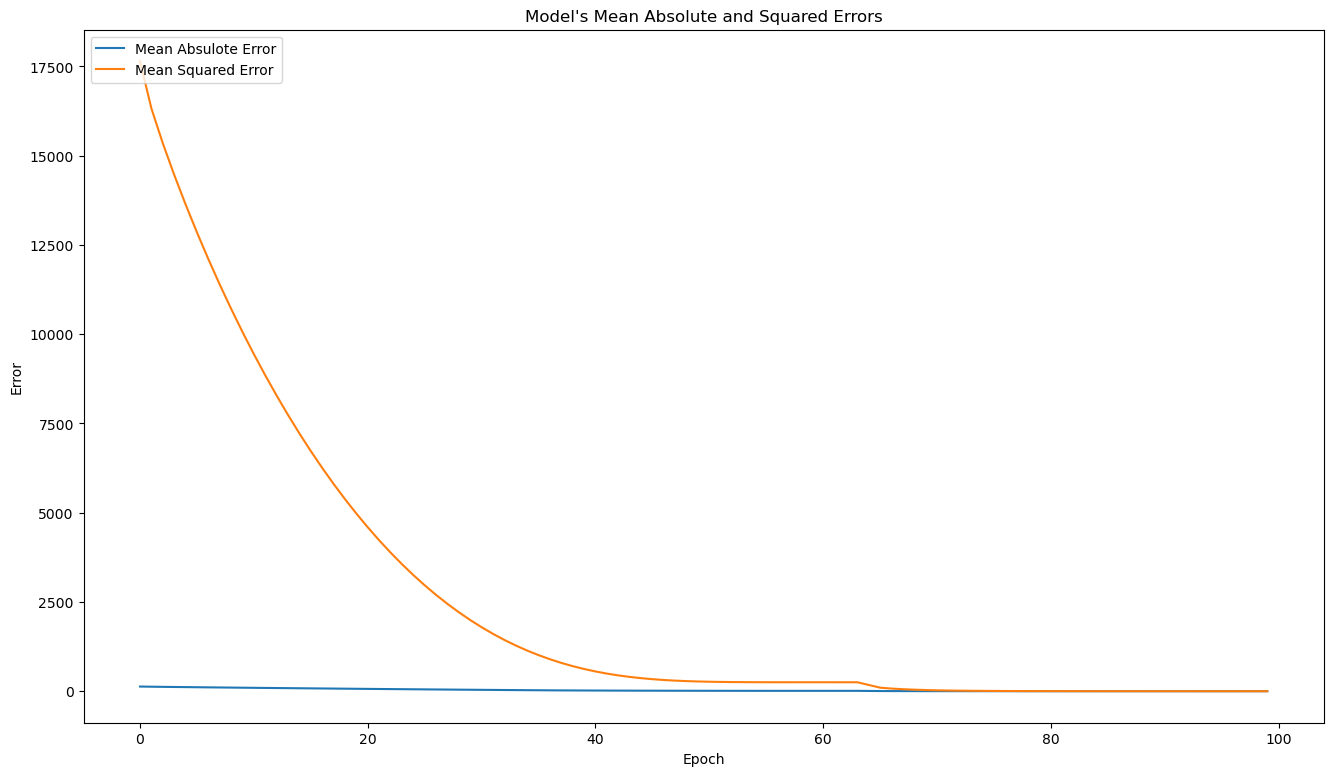

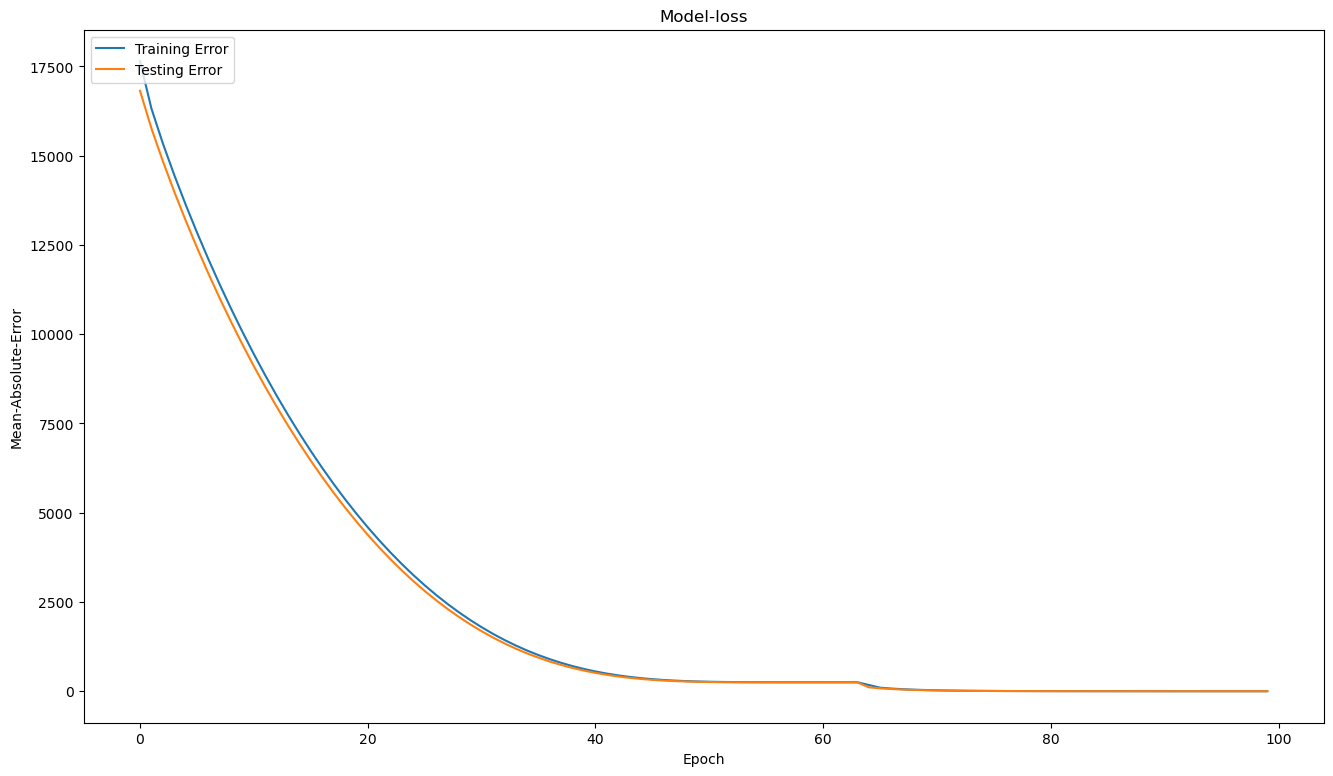

In [79]:
plt.figure(figsize=(16,9))
plt.plot(model.history.history['mae'])
plt.plot(model.history.history['mse'])
plt.title("Model's Mean Absolute and Squared Errors")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Mean Absulote Error', 'Mean Squared Error'],loc = 'upper left')
plt.show()
#summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model-loss')
plt.xlabel('Epoch')
plt.ylabel('Mean-Absolute-Error')
plt.legend(['Training Error', 'Testing Error'],loc='upper left')
plt.show()

In [108]:
x_test = pd.DataFrame(x_test,columns=x.columns)

In [109]:
# generating predictions for test data
y_predict_test = model.predict(x_test) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test.values
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 1s 5ms/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
0,0.105739,0.082165,0.526478,0.617020,-0.260460,-0.318703,0.835564,134.46,134.833298
1,-1.188724,-1.277994,-1.464173,0.577613,-1.301936,0.324554,0.354581,111.88,112.351768
2,0.021436,-0.047454,0.369162,0.536934,0.437015,-0.004500,0.329759,133.72,134.317795
3,0.104833,0.130802,0.550680,0.580155,0.297704,-0.180592,1.201153,133.79,134.186157
4,-1.483332,-1.373111,-1.627540,0.586511,-1.415726,0.147201,0.217138,110.77,111.017982
5,-1.340108,-1.445228,-1.506528,0.606851,-1.091062,1.036797,-2.052870,113.32,113.745331
6,-0.013011,-0.006484,0.357060,0.599224,-0.543554,-0.511544,0.803745,133.77,133.594360
7,-0.547838,-0.525678,-0.266152,0.534392,0.109720,0.021286,-0.708916,128.98,128.703751
8,1.693904,1.700843,0.986324,-2.086836,1.257093,-0.492725,-0.713669,159.42,160.609131
9,1.595097,1.601892,0.980273,-1.869460,2.276600,3.950035,-1.205003,161.86,160.143829


In [110]:
predictions_df.shape

(3008, 9)

# The model is giving the almost similar results.We can use the model for deployment